# Interpreting the effects of COVID-19 on the University of Maryland Fall Semester
**by Allen Tu, Joshua Blume, Zach Mazer** – July 21, 2020<br>
<a href="https://www.kaggle.com/fireballbyedimyrnmom/us-counties-covid-19-dataset">Data</a> by the New York Times

<p>On March 18, 2020, The University of Maryland began operating online due to the coronavirus pandemic. Since then, the country has experienced numerous overlapping responses from federal, state and local governments in an effort to prevent and contain the spread of COVID-19. The state of Maryland, which has spent several months under evolving lockdown orders, is now allowing limited on-campus courses at universities for the Fall semester. This leaves many students considering whether or not it's safe to be on campus and if they should live in residence halls and nearby apartments.</p>

## Case data on coronavirus
<p>Considering the uncertainty of this period, we want to demonstrate the trends of coronavirus in the country and what we could expect in Maryland during the Fall semester with the information currently available to us. We'll primarily be using the coronavirus data compiled by the New York Times, then processing it to demonstrate various facts about the state of the pandemic.</p>
<p>The first thing we'll do is read in the data from the <a href="https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv">'us-counties.csv'</a> file in the <a href="https://github.com/nytimes/covid-19-data">New York Times COVID-19 GitHub</a>. This DataFrame tracks the number of COVID-19 cases and deaths across US counties for each day since 21 January, 2020.</p>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression
from statsmodels.formula.api import ols

url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'
covid = pd.read_csv(url, error_bad_lines=False)
covid

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0
1,2020-01-22,Snohomish,Washington,53061.0,1,0
2,2020-01-23,Snohomish,Washington,53061.0,1,0
3,2020-01-24,Cook,Illinois,17031.0,1,0
4,2020-01-24,Snohomish,Washington,53061.0,1,0
...,...,...,...,...,...,...
350360,2020-07-19,Sweetwater,Wyoming,56037.0,173,2
350361,2020-07-19,Teton,Wyoming,56039.0,208,1
350362,2020-07-19,Uinta,Wyoming,56041.0,221,0
350363,2020-07-19,Washakie,Wyoming,56043.0,43,5


As one can see from the sample above, the data lists the instances recorded by state governments in which someone has tested positive for coronavirus. In order to make this data easier to work with, we merged the county name with the state name in order to clearly distinguish counties in different states with the same name (ex. Orange County, California and Orange County, Florida) and dropped the fips identifier because it is not used by every county. 

In [2]:
# Join county and state column because some counties share a name.
# State column is retained because it is useful for comparison.
covid['county'] = covid['county'].str.cat(covid['state'],sep=", ")
# Drop fips column because other datasets do not use it as an identifier. 
covid.drop(['fips'], axis=1, inplace=True)

covid.head()

,date,county,state,cases,deaths
0,2020-01-21,"Snohomish, Washington",Washington,1,0
1,2020-01-22,"Snohomish, Washington",Washington,1,0
2,2020-01-23,"Snohomish, Washington",Washington,1,0
3,2020-01-24,"Cook, Illinois",Illinois,1,0
4,2020-01-24,"Snohomish, Washington",Washington,1,0


## Visualizations

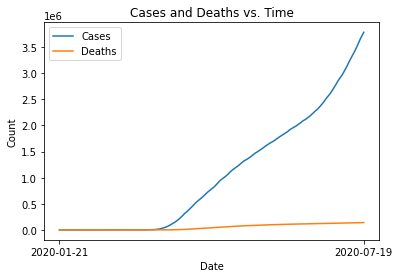

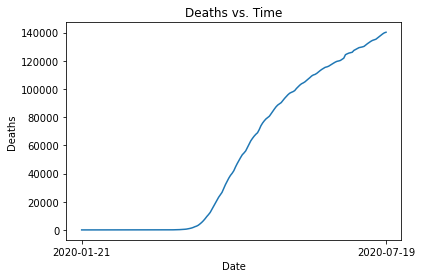

In [3]:
# Calculate total number of cases and deaths for each day. 
cases = covid.groupby('date', as_index=False)[['cases']].sum()
deaths = covid.groupby('date', as_index=False)[['deaths']].sum()

# Plot cases and deaths on a single line chart. 
plt.plot(cases['date'], cases['cases'], label='Cases')
plt.plot(deaths['date'], deaths['deaths'], label='Deaths')
plt.title('Cases and Deaths vs. Time')
plt.xlabel('Date')
plt.xticks([covid.date.min(), covid.date.max()])
plt.ylabel('Count')
plt.legend(loc='upper left')
plt.show()

# Plot only deaths on a single line chart. 
plt.plot(deaths['date'], deaths['deaths'])
plt.title('Deaths vs. Time')
plt.xlabel('Date')
plt.xticks([covid.date.min(), covid.date.max()])
plt.ylabel('Deaths')
plt.show()

Create visualizations for counties and states. 

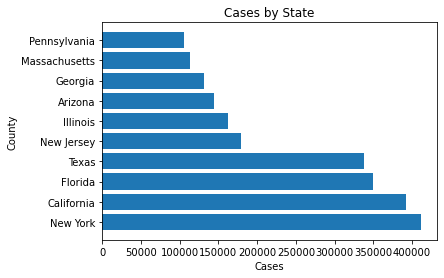

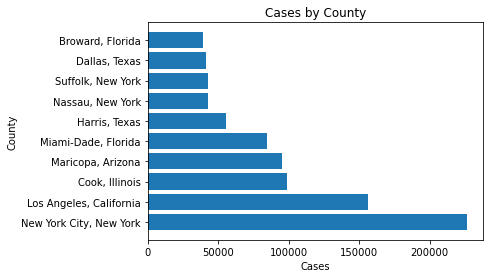

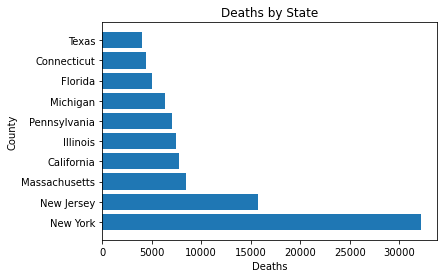

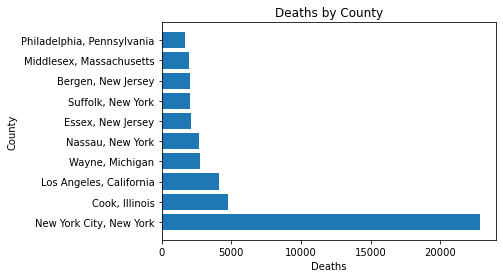

In [4]:
# Select the most current data. 
covid_current = covid.loc[covid['date'] == covid.date.max()]

# Creates top 10 bar chart by county.
def top_10_county(measure):
    # Get top 10 counties for chosen measure.
    bar_chart = covid_current.sort_values(by=measure, ascending=False)
    bar_chart = bar_chart.head(10)
    # Create bar chart.
    plt.barh(bar_chart['county'], bar_chart[measure])
    plt.title(measure.capitalize() + ' by County')
    plt.xlabel(measure.capitalize())
    plt.ylabel('County')
    plt.show()
    
# Creates top 10 bar chart by state.
def top_10_state(measure):    
    bar_chart = covid_current.groupby('state', as_index=False)[[measure]].sum()
    bar_chart = bar_chart.sort_values(by=measure, ascending=False)
    bar_chart = bar_chart.head(10)
    bar_chart.describe()
    # Create bar chart.
    plt.barh(bar_chart['state'], bar_chart[measure])
    plt.title(measure.capitalize() + ' by State')
    plt.xlabel(measure.capitalize())
    plt.ylabel('County')
    plt.show() 
    
# Top 10 cases and deaths for states and counties. 
top_10_state('cases')
top_10_county('cases')
top_10_state('deaths')
top_10_county('deaths')

# Linear Regression by State

In [5]:
# D.C., Guam, Northern Mariana Islands, Puerto Rico, and Virign Islands account for the 5 extra rows.
groups = covid.groupby('state')
state_list = []
s_names = []
for state, g in groups:
    state_list.append(g)
    s_names.append(state)

# Calculate total cases for each state.
cases = {}
for i, state in enumerate(state_list):
    total = state['cases'].sum()
    cases[s_names[i]] = total
# Create dataframe for total cases by state. 
simple_df = pd.DataFrame(list(cases.items()),columns = ['state','cases'])
simple_df.head()

,state,cases
0,Alabama,2282500
1,Alaska,75804
2,Arizona,4035504
3,Arkansas,1123410
4,California,14260987


## Explain this scraping. 

In [6]:
# Scrape population data by state from website.
pop_list = pd.read_html("https://www.infoplease.com/us/states/state-population-by-rank")
pop_list

[   Rank           State  July 2019 Estimate Percent of Total
 0     1      California            39512223           11.91%
 1     2           Texas            28995881            8.74%
 2     3         Florida            21477737            6.47%
 3     4        New York            19453561            5.86%
 4     5        Illinois            12671821            3.86%
 5     6    Pennsylvania            12801989            3.82%
 6     7            Ohio            11689100            3.52%
 7     8         Georgia            10617423            3.20%
 8     9  North Carolina            10488084            3.16%
 9    10        Michigan             9986857            3.01%
 10   11      New Jersey             8882190            2.68%
 11   12        Virginia             8535519            2.57%
 12   13      Washington             7614893            2.29%
 13   14         Arizona             7278717            2.19%
 14   15   Massachusetts             6949503            2.09%
 15   16

## Processing

In [7]:
# Create dataframe for population by state.
pop_df = pop_list[0]
pop_df.columns = ['rank', 'state', 'pop', 'percent of total pop']

# Merge dataframes into a dataframe for population and cases by state. 
covid_pop = pd.merge(left=pop_df, right=simple_df, left_on='state', right_on='state')
covid_pop = covid_pop.drop(columns=['percent of total pop'])

covid_pop.head()

,rank,state,pop,cases
0,1,California,39512223,14260987
1,2,Texas,28995881,9838629
2,3,Florida,21477737,9488828
3,4,New York,19453561,36999340
4,5,Illinois,12671821,10603152


## Explain model

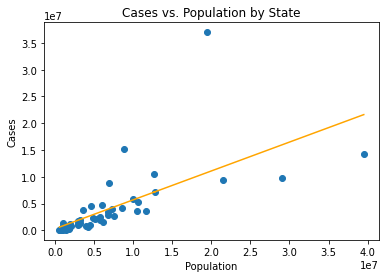

Predicted Cases = 0.539778292185303 * Population + 286774.6205221107
p-value: 1.260797666030277e-07


In [8]:
# Create linear regression model.
pop = covid_pop['pop'].values.reshape(-1,1)
cases = covid_pop['cases'].values.reshape(-1,1)
model = LinearRegression()
model.fit(pop, cases)
predicted = model.predict(pop)
# Calculate p-value.A small p-value indicates strong evidence against the null hypothesis.
F = f_regression(pop, cases, center=True)

# Create scatterplot for cases across population by state. 
plt.plot(pop,predicted, color='orange')
plt.scatter(pop, cases)
plt.title("Cases vs. Population by State")
plt.xlabel('Population')
plt.ylabel('Cases')
plt.show()
# Print fitted model.
print('Predicted Cases = ' + str(model.coef_[0][0]) + ' * Population + ' + str(model.intercept_[0]))
print('p-value: '+ str(F[1][0]))

## Analysis of Model

# Linear Regression by County

https://www.census.gov/data/datasets/time-series/demo/popest/2010s-counties-total.html

In [9]:
# Read census from xlsx.
census = pd.read_excel('co-est2019-annres.xlsx')
census.head()

,County,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,".Autauga County, Alabama",54773.0,55227.0,54954.0,54727.0,54893.0,54864.0,55243.0,55390.0,55533.0,55869.0
1,".Baldwin County, Alabama",183112.0,186558.0,190145.0,194885.0,199183.0,202939.0,207601.0,212521.0,217855.0,223234.0
2,".Barbour County, Alabama",27327.0,27341.0,27169.0,26937.0,26755.0,26283.0,25806.0,25157.0,24872.0,24686.0
3,".Bibb County, Alabama",22870.0,22745.0,22667.0,22521.0,22553.0,22566.0,22586.0,22550.0,22367.0,22394.0
4,".Blount County, Alabama",57376.0,57560.0,57580.0,57619.0,57526.0,57526.0,57494.0,57787.0,57771.0,57826.0


## Explain preprocessing

In [10]:
# Drop NaN columns (all footnotes).
census = census.dropna()

# Format county to match the COVID Dataset. 
census.rename(columns={'County':'county'}, inplace=True)
census['county'] = census['county'].str.replace('.','')
census['county'] = census['county'].str.replace(' County','')
# Add state column to match the COVID Dataset.
census['state'] = census['county'].str.partition(', ')[2] 
# Reorder columns.
census = census[['county','state',2010,2011,2012,2013,2014,2015,2016,2017,2018,2019]]

census.head()

,county,state,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,"Autauga, Alabama",Alabama,54773.0,55227.0,54954.0,54727.0,54893.0,54864.0,55243.0,55390.0,55533.0,55869.0
1,"Baldwin, Alabama",Alabama,183112.0,186558.0,190145.0,194885.0,199183.0,202939.0,207601.0,212521.0,217855.0,223234.0
2,"Barbour, Alabama",Alabama,27327.0,27341.0,27169.0,26937.0,26755.0,26283.0,25806.0,25157.0,24872.0,24686.0
3,"Bibb, Alabama",Alabama,22870.0,22745.0,22667.0,22521.0,22553.0,22566.0,22586.0,22550.0,22367.0,22394.0
4,"Blount, Alabama",Alabama,57376.0,57560.0,57580.0,57619.0,57526.0,57526.0,57494.0,57787.0,57771.0,57826.0


## Explain cc_current

In [11]:
# Build current dataset for covid and census.
# Only use census data from this year.
cc_current = census[['county', 'state', 2019]]
cc_current = cc_current.rename(columns={2019:'population'})

# Select all counties that appear in both datasets.
covid_current['county'] = covid_current['county'].str.replace(' Parish','')
covid_current = covid_current[covid_current['county'].isin(census.county.unique())]
cc_current = cc_current[cc_current['county'].isin(covid_current.county.unique())]

# Alphabetize by county.
covid_current = covid_current.sort_values(by='county')
covid_current.reset_index(inplace=True,drop=True)
cc_current.sort_values(by='county', inplace=True)
cc_current.reset_index(inplace=True,drop=True)

# Add cases and deaths to current dataset. 
cc_current['cases'] = covid_current['cases']
cc_current['deaths'] = covid_current['deaths']

cc_current.head()

,county,state,population,cases,deaths
0,"Abbeville, South Carolina",South Carolina,24527.0,190,2
1,"Accomack, Virginia",Virginia,32316.0,1052,15
2,"Ada, Idaho",Idaho,481587.0,5900,32
3,"Adair, Iowa",Iowa,7152.0,20,0
4,"Adair, Kentucky",Kentucky,19202.0,176,19


## Explain Model

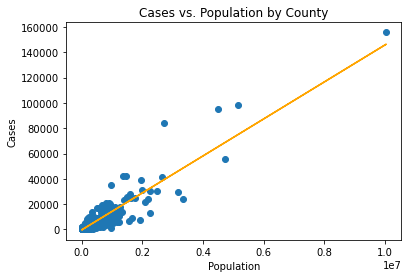

Predicted Cases = 0.014616688001602053 * Population + -379.5253056632839
p-value: 0.0


In [12]:
# Model cases across population
X = pd.DataFrame(cc_current['population'])
y = pd.DataFrame(cc_current['cases'])
# Create linear regression model.
model = LinearRegression()
model.fit(X, y)
coef = model.coef_[0][0]
intercept = model.intercept_[0]
# Calculate p-value.A small p-value indicates strong evidence against the null hypothesis.
F = f_regression(X, y.values.ravel(), center=True)

# Create scatterplot of cases vs. population.
plt.scatter(cc_current['population'], cc_current['cases'])
plt.title('Cases vs. Population by County')
plt.xlabel('Population')
plt.ylabel('Cases')
# Plot regression line
plt.plot(cc_current['population'], coef * cc_current['population'] + intercept,  color='orange')
plt.show()
# Print fitted model.
print('Predicted Cases = ' + str(coef) + ' * Population + ' + str(intercept))
print('p-value: '+ str(F[1][0]))

## Analysis of Model

## Maryland only

In [13]:
# Create dataframe for Maryland's current data.
md_current = cc_current.loc[cc_current['state'] == 'Maryland']
md_current.reset_index(inplace=True,drop=True)

md_current

,county,state,population,cases,deaths
0,"Allegany, Maryland",Maryland,70416.0,237,18
1,"Anne Arundel, Maryland",Maryland,579234.0,5963,213
2,"Baltimore city, Maryland",Maryland,593490.0,9442,382
3,"Baltimore, Maryland",Maryland,827370.0,9743,510
4,"Calvert, Maryland",Maryland,92525.0,491,27
5,"Caroline, Maryland",Maryland,33406.0,360,3
6,"Carroll, Maryland",Maryland,168447.0,1272,116
7,"Cecil, Maryland",Maryland,102855.0,554,29
8,"Charles, Maryland",Maryland,163257.0,1611,90
9,"Dorchester, Maryland",Maryland,31929.0,245,5


## Create scatterplot

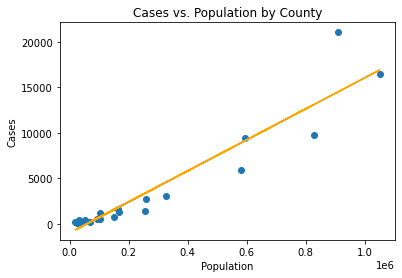

Predicted Cases = 0.017046168484051456 * Population + -1008.5117085232837
p-value: 1.1303271111153216e-11


In [14]:
# Model cases across population
X = pd.DataFrame(md_current['population'])
y = pd.DataFrame(md_current['cases'])
# Create linear regression model.
model = LinearRegression()
model.fit(X, y)
coef = model.coef_[0][0]
intercept = model.intercept_[0]
# Calculate p-value.A small p-value indicates strong evidence against the null hypothesis.
F = f_regression(X, y.values.ravel(), center=True)

# Create scatterplot of cases vs. population.
plt.scatter(md_current['population'], md_current['cases'])
plt.title('Cases vs. Population by County')
plt.xlabel('Population')
plt.ylabel('Cases')
# Plot regression line
plt.plot(md_current['population'], coef * md_current['population'] + intercept,  color='orange')
plt.show()
# Print fitted model.
print('Predicted Cases = ' + str(coef) + ' * Population + ' + str(intercept))
print('p-value: '+ str(F[1][0]))

https://irpa.umd.edu/CampusCounts/Enrollments/stuprofile_allug.pdf

Students living in residence halls are more likely to live outside of Prince George County. In Fall 2019, 11,902 UMD students were housed in residence halls.

In [15]:
coef * 11902

202.8834972971804

According to the linear regression model,  if residence halls were opened and filled to normal capacity, there would be a predicted 153 new cases in Prince George County.